In [1]:
import zipfile
import os

zip_path = "/content/CASIA-Iris-Interval-20250617T034139Z-1-001.zip"  # Replace with your actual filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_Iris-Interval")

In [6]:
import os
import shutil
import random

def get_all_images_recursive(class_path):
    images = []
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))
    return images

def split_dataset(input_dir, output_dir, train_ratio=0.625, val_ratio=0.25, test_ratio=0.125):
    os.makedirs(output_dir, exist_ok=True)
    class_names = os.listdir(input_dir)

    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = get_all_images_recursive(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_imgs:
                img_name = os.path.basename(img_path)
                dst = os.path.join(split_dir, img_name)
                shutil.copy2(img_path, dst)

# ✅ Update your dataset paths
input_dataset_folder = "/content/unzipped_Iris-Interval/CASIA-Iris-Interval"
output_dataset_folder = "/content/split_dataset"

# ✅ Run
split_dataset(input_dataset_folder, output_dataset_folder)


In [ ]:
!pip install tensorflow

In [7]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

In [8]:
mg_height, img_width = (224,224)
batch_size = 16

train_data_dir = r"/content/split_dataset/train"
valid_data_dir = r"/content/split_dataset/val"
test_data_dir = r"/content/split_dataset/test"


In [9]:
import os

def count_images_in_directory(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                total += 1
    return total



# Count and print
print(f" Number of training images: {count_images_in_directory(train_data_dir)}")
print(f" Number of validation images: {count_images_in_directory(valid_data_dir)}")
print(f" Number of test images: {count_images_in_directory(test_data_dir)}")


 Number of training images: 2151
 Number of validation images: 1018
 Number of test images: 936


In [10]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as training data

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as validation data

Found 2151 images belonging to 240 classes.
Found 1018 images belonging to 240 classes.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # or use VGG16's preprocess_input

# Define test image data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Then use it here
test_generator = test_datagen.flow_from_directory(
    "/content/split_dataset/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 936 images belonging to 240 classes.


In [12]:
x, y = next(test_generator)
x.shape

(16, 256, 256, 3)

In [13]:
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
#Removes the original classifier (1000-class softmax), leaving just the convolutional base.
x = GlobalAveragePooling2D()(x)
#Add your own classifer on top,GlobalAveragePooling → flattens feature maps into 1 vector per channel
x = Dense(1024, activation='relu')(x)
#Dense(num_classes, softmax) → predicts your own classes, not ImageNet’s 1000
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Create an instance of the Adam optimizer with a specific learning rate (e.g., 0.0002)
custom_optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20  # or your desired number of epochs
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.0605 - loss: 5.3672 - val_accuracy: 0.3261 - val_loss: 3.6617
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.3648 - loss: 3.3821 - val_accuracy: 0.6523 - val_loss: 2.1798
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.6875 - loss: 1.8887 - val_accuracy: 0.8301 - val_loss: 1.2611
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8538 - loss: 1.1041 - val_accuracy: 0.9194 - val_loss: 0.7310
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9270 - loss: 0.6301 - val_accuracy: 0.9371 - val_loss: 0.5185
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9609 - loss: 0.4006 - val_accuracy: 0.9676 - val_loss: 0.3670
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9901 - loss: 0.2413 - val_accuracy: 0.9764 - val_loss: 0.2778
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9946 - loss: 0.1619 - val_accura

In [14]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

59/59 - 6s - 107ms/step - accuracy: 0.9818 - loss: 0.1458

Test accuracy: 0.9818376302719116


In [15]:
!mkdir -p /content/drive/MyDrive/Iris_Model1

In [16]:
model.save('/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score, recall_score
import seaborn as sns
from tqdm import tqdm
import os
import datetime

def evaluate_model(model_path, test_dir, target_size=(256, 256), output_dir="evaluation_results"):
    """
    Evaluate a trained model on test data with comprehensive metrics and visualizations.
    Includes detailed debugging for confusion matrix issues.
    """
    try:
        # Create output directory
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Load model
        try:
            model = load_model(model_path)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return

        # Create test data generator with consistent target size
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=16,
            class_mode='categorical',
            shuffle=False
        )
        print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes.")

        # Create index-to-class mapping
        class_indices = test_generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
        class_labels = list(class_indices.keys())
        print(f"Class indices: {class_indices}")

        # Evaluate model to get a baseline
        test_loss, test_acc = model.evaluate(test_generator, verbose=2)
        print(f"\nTest accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")

        # Make predictions with explicit steps
        test_generator.reset()
        num_samples = test_generator.samples
        predictions = model.predict(test_generator, steps=int(num_samples / test_generator.batch_size), verbose=1)
        predicted_classes = np.argmax(predictions[:num_samples], axis=1)  # Ensure length matches
        true_classes = test_generator.classes[:num_samples]

        # Debugging prints
        print(f"Number of true classes: {len(true_classes)}")
        print(f"Number of predicted classes: {len(predicted_classes)}")
        print(f"Sample predictions: {predicted_classes[:10]}")
        print(f"Sample true classes: {true_classes[:10]}")
        print(f"Max prediction value: {np.max(predictions)}")
        print(f"Min prediction value: {np.min(predictions)}")

        # Verify and adjust lengths
        if len(true_classes) != len(predicted_classes):
            print(f"Warning: Mismatch in lengths - True: {len(true_classes)}, Predicted: {len(predicted_classes)}")
            min_length = min(len(true_classes), len(predicted_classes))
            true_classes = true_classes[:min_length]
            predicted_classes = predicted_classes[:min_length]
        else:
            print("Lengths match successfully")

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"Confusion matrix shape: {cm.shape}")
        print(f"Confusion matrix content:\n{cm}")

        # Plot full confusion matrix for first 10 classes
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',  # Limit to 10x10 for readability
                    xticklabels=class_labels[:10],
                    yticklabels=class_labels[:10])
        plt.title('Confusion Matrix (First 10 Classes)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
        plt.close()

        macro_precision = precision_score(true_classes, predicted_classes, average="macro", zero_division=0)  
        macro_recall    = recall_score   (true_classes, predicted_classes, average="macro", zero_division=0)  
        macro_f1        = f1_score       (true_classes, predicted_classes, average="macro", zero_division=0) 

        # Calculate and save classification report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))
        with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
            f.write(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

        # Save overall metrics
        accuracy = np.mean(predicted_classes == true_classes)
        metrics = {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'overall_accuracy': accuracy,
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Evaluation results saved in {output_dir}")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5'
    test_dir = "/content/split_dataset/test"
    evaluate_model(model_path, test_dir, target_size=(256, 256))

Model loaded successfully
Found 936 images belonging to 240 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 936 images belonging to 240 classes.
Class indices: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67, '069': 68, '070': 69, '071': 70, '072': 71, '073': 72, '074': 73, '075': 74, '076': 75, '077': 76, '078': 77, '079': 78, '080': 79, '081': 80, '082': 81, '083': 82, '084': 83, '085': 84, '086': 85, '087'

    epoch  accuracy  val_accuracy      loss  val_loss  learning_rate
0       1  0.103208      0.326130  4.945147  3.661691         0.0002
1       2  0.421199      0.652259  3.095206  2.179755         0.0002
2       3  0.713622      0.830059  1.722312  1.261125         0.0002
3       4  0.872153      0.919450  0.971115  0.730969         0.0002
4       5  0.934449      0.937132  0.577418  0.518474         0.0002
5       6  0.964668      0.967583  0.371709  0.367019         0.0002
6       7  0.987913      0.976424  0.232584  0.277831         0.0002
7       8  0.995351      0.976424  0.159071  0.225888         0.0002
8       9  0.998140      0.984283  0.110982  0.178813         0.0002
9      10  1.000000      0.983301  0.082828  0.157013         0.0002
10     11  1.000000      0.988212  0.063767  0.132091         0.0002
11     12  0.999535      0.985265  0.050688  0.120234         0.0002
12     13  1.000000      0.986248  0.041553  0.108539         0.0002
13     14  1.000000      0.988212 

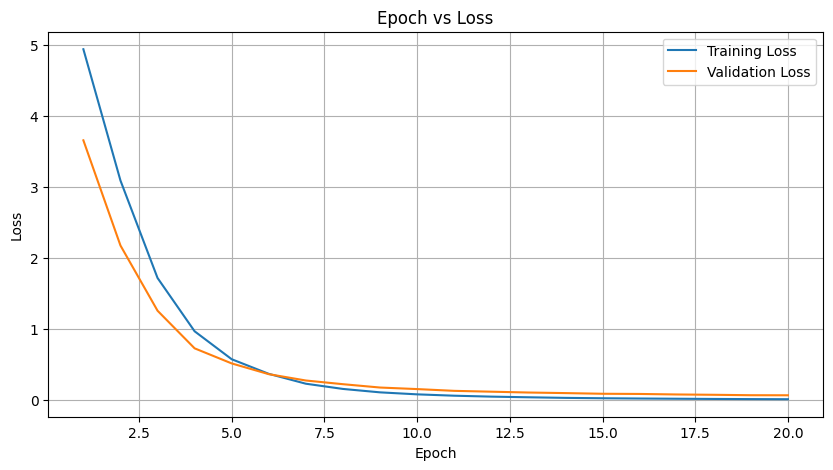

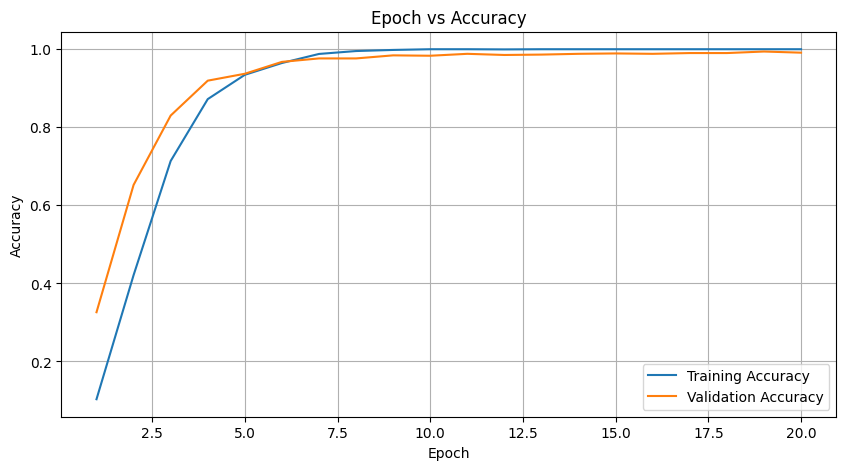

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a results dictionary from history object
results = {
    'epoch': list(range(1, len(history.history['accuracy']) + 1)),
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'learning_rate': [float(tf.keras.backend.get_value(model.optimizer.learning_rate))] * len(history.history['accuracy'])
}

# Create a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV (optional)
results_df.to_csv("evaluation_results/training_metrics_table.csv", index=False)

# Plot Epoch vs. Loss
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['loss'], label='Training Loss')
plt.plot(results['epoch'], results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_loss.png")
plt.show()

# Plot Epoch vs. Accuracy
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['accuracy'], label='Training Accuracy')
plt.plot(results['epoch'], results['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_accuracy.png")
plt.show()